In [72]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import chi2
import matplotlib.pyplot as plt

In [83]:
def _spectral_decomp_topK(X, K):
    """
    Compute top-K eigenpairs of symmetric matrix X, ordered by |eigenvalue| descending.
    """
    w, V = np.linalg.eigh(X)
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    d_hat = w[idx_top]
    V_hat = V[:, idx_top]
    return d_hat, V_hat

def _row_variances_from_spectral(V_hat, d_hat, t):
    """
    Approximate row t of H = V_hat diag(d_hat) V_hat^T,
    then variance row sigma^2_tl = h_tl (1 - h_tl).
    """
    temp = V_hat[t, :] * d_hat
    h_row = temp @ V_hat.T
    h_row = np.clip(h_row, 1e-6, 1 - 1e-6)
    var_row = h_row * (1.0 - h_row)
    return var_row

def _sigma1_hat_for_pair(V_hat, d_hat, i, j):
    """
    Plug-in estimator for Σ1 for a given pair (i,j).
    """
    n, K = V_hat.shape
    Sigma = np.zeros((K, K))

    var_i = _row_variances_from_spectral(V_hat, d_hat, i)
    var_j = _row_variances_from_spectral(V_hat, d_hat, j)

    h_ij = float(np.dot(V_hat[i, :] * d_hat, V_hat[j, :]))
    h_ij = float(np.clip(h_ij, 1e-6, 1 - 1e-6))
    sigma_ij2 = h_ij * (1.0 - h_ij)

    for a in range(K):
        va = V_hat[:, a]
        for b in range(K):
            vb = V_hat[:, b]
            prod = va * vb
            sum_term = np.dot(var_i, prod) + np.dot(var_j, prod)
            correction = sigma_ij2 * (va[j] * vb[i] + va[i] * vb[j])
            Sigma[a, b] = (sum_term - correction) / (d_hat[a] * d_hat[b])

    return Sigma

def simple_Tij(X, i, j, K, ridge=1e-6, use_pinv=False):
    """
    SIMPLE test statistic T_ij for mixed membership model (Model 1).
    """
    n = X.shape[0]
    assert 0 <= i < n and 0 <= j < n and i != j

    d_hat, V_hat = _spectral_decomp_topK(X, K)
    Sigma1_hat = _sigma1_hat_for_pair(V_hat, d_hat, i, j)
    Sigma1_reg = Sigma1_hat + ridge * np.eye(K)

    if use_pinv:
        Sigma1_inv = np.linalg.pinv(Sigma1_reg)
    else:
        Sigma1_inv = np.linalg.inv(Sigma1_reg)

    diff = V_hat[i, :] - V_hat[j, :]
    T_ij = float(diff @ Sigma1_inv @ diff)
    return T_ij

def spectral_clustering_memberships(A, K, random_state=0):
    # Symmetric matrix, use eigh
    w, V = np.linalg.eigh(A)
    # Sort by absolute eigenvalue descending
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    V_top = V[:, idx_top]

    # Row-normalize (common in spectral clustering)
    row_norms = np.linalg.norm(V_top, axis=1, keepdims=True) + 1e-12
    X_spec = V_top / row_norms

    # K-means on spectral embedding
    km = KMeans(n_clusters=K, n_init=20, random_state=random_state)
    labels = km.fit_predict(X_spec)

    # Convert to one-hot membership matrix (n x K)
    Pi_hat = np.zeros((A.shape[0], K))
    Pi_hat[np.arange(A.shape[0]), labels] = 1.0

    return labels, Pi_hat, V_top


def plot_airport_network(A, lats, lons, labels, max_edges=5000, alpha_edges=0.35):
    n = A.shape[0]

    # Node colors by cluster
    K = labels.max() + 1
    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(10, 6))

    # Draw a subset of edges
    edges = np.transpose(np.nonzero(np.triu(A, 1)))
    if len(edges) > max_edges:
        idx_sample = np.random.choice(len(edges), size=max_edges, replace=False)
        edges = edges[idx_sample]

    for (i, j) in edges:
        plt.plot(
            [lons[i], lons[j]],
            [lats[i], lats[j]],
            linewidth=0.3,
            alpha=alpha_edges
        )

    # Draw nodes
    for k in range(K):
        idx_k = np.where(labels == k)[0]
        plt.scatter(
            lons[idx_k],
            lats[idx_k],
            s=10,
            label=f"Community {k}",
            alpha=0.8
        )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Airport Network (Spectral Communities)")
    # plt.legend(loc="best", fontsize=8)
    plt.grid(True, linewidth=0.2)
    plt.tight_layout()
    plt.show()

def pick_random_airports_per_cluster(labels, airports, K, per_cluster=1, seed=0):
    """
    Randomly pick airports from each cluster.

    Returns:
        selected_idx: list of node indices
        selected_names: list of "AirportName (Ck)"
    """
    rng = np.random.default_rng(seed)
    selected_idx = []
    selected_names = []

    for k in range(K):
        idx_k = np.where(labels == k)[0]
        if len(idx_k) == 0:
            continue

        # random choice without replacement
        num = min(per_cluster, len(idx_k))
        chosen = rng.choice(idx_k, size=num, replace=False)

        for i in chosen:
            name = airports.iloc[i]["Name"]
            selected_idx.append(i)
            selected_names.append(f"{name} (C{k})")

    return selected_idx, selected_names

def pvalue_matrix_for_airports(A, idx_list, K):
    """
    Build p-value matrix for the airports in idx_list using SIMPLE test.
    """
    m = len(idx_list)
    pmat = np.ones((m, m), dtype=float)

    for a in range(m):
        for b in range(m):
            if a == b:
                pmat[a, b] = 1.0
                continue
            i = idx_list[a]
            j = idx_list[b]
            T_ij = simple_Tij(A, i, j, K)
            p_ij = 1.0 - chi2.cdf(T_ij, df=K)
            pmat[a, b] = p_ij
    return pmat



In [74]:
# Load ariports information
# Columns from OpenFlights airports.dat docs
airport_cols = [
    "AirportID", "Name", "City", "Country",
    "IATA", "ICAO", "Latitude", "Longitude",
    "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
    "Type", "Source"
]

airports = pd.read_csv(
    "airports.dat",
    header=None,
    names=airport_cols,
    na_values="\\N"
)

# Keep only real airports
airports = airports[airports["Type"] == "airport"].copy()

# Load routes
route_cols = [
    "Airline", "AirlineID",
    "SourceAirport", "SourceAirportID",
    "DestAirport", "DestAirportID",
    "Codeshare", "Stops", "Equipment"
]

routes = pd.read_csv(
    "routes.dat",
    header=None,
    names=route_cols,
    na_values="\\N"
)

# Drop routes with missing airport IDs
routes = routes.dropna(subset=["SourceAirportID", "DestAirportID"]).copy()
routes["SourceAirportID"] = routes["SourceAirportID"].astype(int)
routes["DestAirportID"]   = routes["DestAirportID"].astype(int)

# Restrict to airports that appear in routes
used_ids = set(routes["SourceAirportID"]).union(set(routes["DestAirportID"]))
airports = airports[airports["AirportID"].isin(used_ids)].copy()

# Reindex airports
airports = airports.sort_values("AirportID").reset_index(drop=True)
n = len(airports)
print("Number of airports in network:", n)

# Mapping AirportID with index
id_to_idx = {aid: i for i, aid in enumerate(airports["AirportID"].tolist())}

# Build adjacency matrix based on the routes
A = np.zeros((n, n), dtype=int)

for _, row in routes.iterrows():
    sid = row["SourceAirportID"]
    did = row["DestAirportID"]
    if sid in id_to_idx and did in id_to_idx:
        i = id_to_idx[sid]
        j = id_to_idx[did]
        if i != j:
            A[i, j] = 1
            A[j, i] = 1  # undirected

np.fill_diagonal(A, 0)

print("Number of edges:", A.sum() // 2)

Number of airports in network: 3218
Number of edges: 18858


### We consider to find memberships using spectral clustering.
### Case1: Assume that there are 10 communities.

In [75]:
# Find memberships using spectral clustering
K = 5 # Number of community
labels, Pi_hat, V_top = spectral_clustering_memberships(A, K)
print("Cluster sizes:", np.bincount(labels))

Cluster sizes: [1118  764  539  325  472]


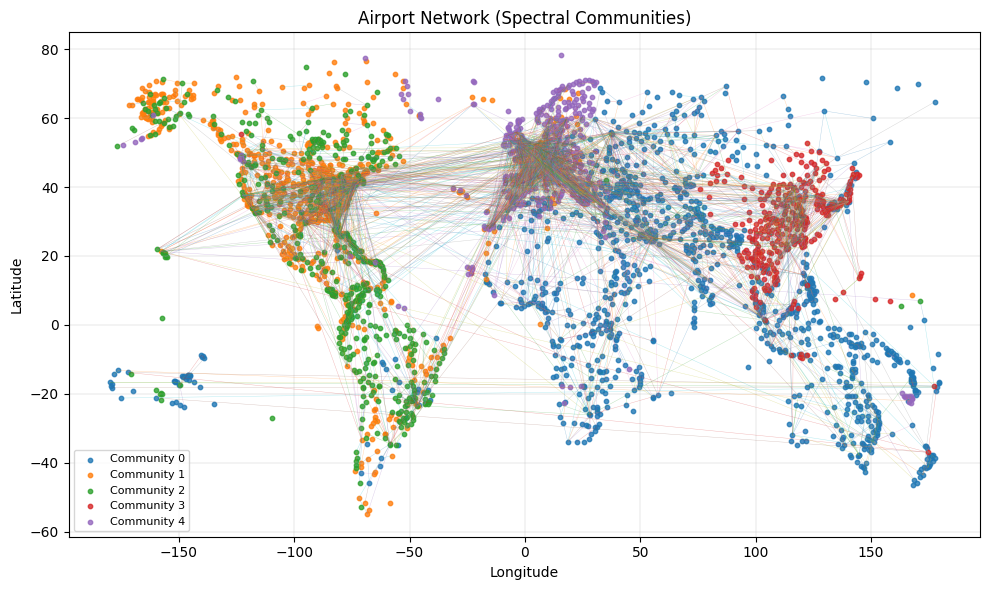

In [76]:
# Extract coordinates
lats = airports["Latitude"].values
lons = airports["Longitude"].values

# Cluster plot based on spectral clustering
plot_airport_network(A, lats, lons, labels)

Cross cluster p-value  

In [77]:
# Choose 1 airports per cluster
selected_idx, selected_names = pick_random_airports_per_cluster(
    labels, airports, K, per_cluster=1, seed=42
)

# p-value matrix for different cluster
pmat_airports = pvalue_matrix_for_airports(A, selected_idx, K)
df_p_airports = pd.DataFrame(pmat_airports,
                             index=selected_names,
                             columns=selected_names)

print("\nP-value matrix for selected airports:")
print(df_p_airports.round(5))



P-value matrix for selected airports:
                                                    Toliara Airport (C0)  \
Toliara Airport (C0)                                             1.00000   
Chippewa Valley Regional Airport (C1)                            0.79145   
Minneapolis-St Paul International/Wold-Chamberl...               0.00000   
Nakhon Si Thammarat Airport (C3)                                 0.99488   
Badajoz Airport (C4)                                             0.72101   

                                                    Chippewa Valley Regional Airport (C1)  \
Toliara Airport (C0)                                                              0.79145   
Chippewa Valley Regional Airport (C1)                                             1.00000   
Minneapolis-St Paul International/Wold-Chamberl...                                0.00000   
Nakhon Si Thammarat Airport (C3)                                                  0.73086   
Badajoz Airport (C4)                   

p-value of 5 random airports in the same cluster(cluster 2)

In [78]:
# Choose 5 airports from a specific cluster (randomly)
cluster_id = 2
rng = np.random.default_rng(1234)

idx_cluster = np.where(labels == cluster_id)[0]

chosen_idx = rng.choice(idx_cluster, size=5, replace=False)
chosen_names = [airports.iloc[i]["Name"] for i in chosen_idx]

# ----- Build p-value matrix -----
m = len(chosen_idx)
pvals = np.ones((m, m), dtype=float)

for a in range(m):
    for b in range(m):
        if a == b:
            pvals[a, b] = 1.0
            continue
        i = chosen_idx[a]
        j = chosen_idx[b]
        T_ij = simple_Tij(A, i, j, K)
        p_ij = 1.0 - chi2.cdf(T_ij, df=K)
        pvals[a, b] = p_ij

df_p_cluster = pd.DataFrame(pvals,
                            index=chosen_names,
                            columns=chosen_names)

print("\nP-value matrix for 5 RANDOM airports in cluster", cluster_id)
print(df_p_cluster.round(5))



P-value matrix for 5 RANDOM airports in cluster 2
                                  Senadora Eunice Micheles Airport  \
Senadora Eunice Micheles Airport                           1.00000   
São Félix do Xingu Airport                                 1.00000   
Perales Airport                                            0.99487   
Los Alamos Airport                                         0.97939   
Jardines Del Rey Airport                                   0.44086   

                                  São Félix do Xingu Airport  Perales Airport  \
Senadora Eunice Micheles Airport                     1.00000          0.99487   
São Félix do Xingu Airport                           1.00000          0.99481   
Perales Airport                                      0.99481          1.00000   
Los Alamos Airport                                   0.97926          0.99930   
Jardines Del Rey Airport                             0.44044          0.62501   

                                  Los Ala

### Case 2: Assume that there are 50 communities.

In [79]:
# Find memberships using spectral clustering
K = 50 # Number of community
labels, Pi_hat, V_top = spectral_clustering_memberships(A, K)
print("Cluster sizes:", np.bincount(labels))

Cluster sizes: [121  96  82  47  54  65 129  74  58 103  48  16  60  83  71  48  81  57
  52  74  56  59  69  45  43 103  48  61 108  88  70  32  63  76  60  34
  84  87  55  43  70  37  46  52  54  53  42  42  65  54]


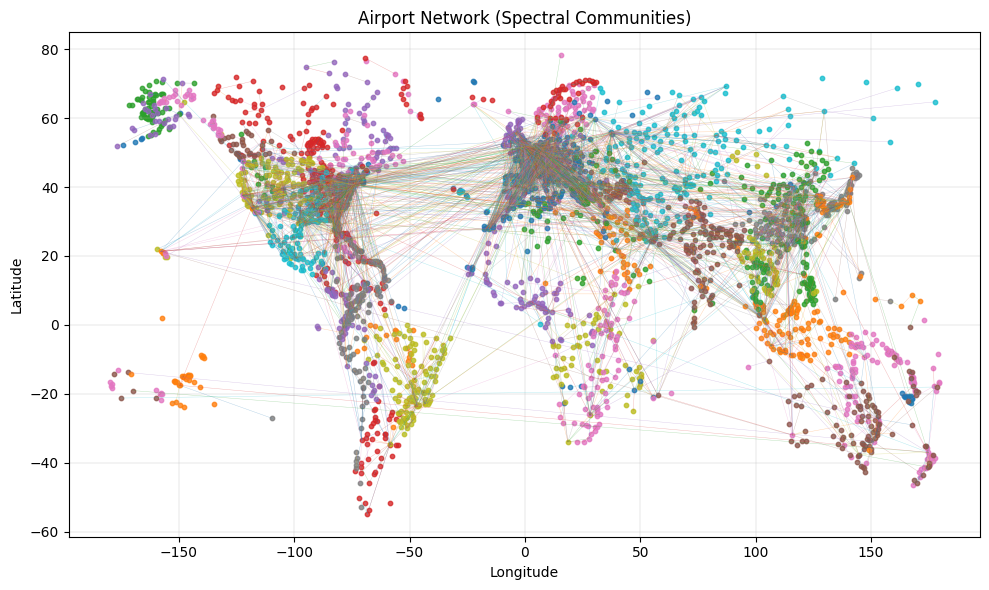

In [84]:
# Extract coordinates
lats = airports["Latitude"].values
lons = airports["Longitude"].values

# Cluster plot based on spectral clustering
plot_airport_network(A, lats, lons, labels)

Cross cluster p-value  

In [81]:
# Choose 1 airports per cluster, only choose from the first 5 clusters
selected_idx, selected_names = pick_random_airports_per_cluster(
    labels, airports, K=5, per_cluster=1, seed=42
)


# p-value matrix for different cluster
pmat_airports = pvalue_matrix_for_airports(A, selected_idx, K)
df_p_airports = pd.DataFrame(pmat_airports,
                             index=selected_names,
                             columns=selected_names)

print("\nP-value matrix for selected airports:")
print(df_p_airports.round(5))



P-value matrix for selected airports:
                                              Manchester Airport (C0)  \
Manchester Airport (C0)                                           1.0   
Mulu Airport (C1)                                                 0.0   
Buckland Airport (C2)                                             0.0   
Treasure Cay Airport (C3)                                         0.0   
Lester B. Pearson International Airport (C4)                      0.0   

                                              Mulu Airport (C1)  \
Manchester Airport (C0)                                     0.0   
Mulu Airport (C1)                                           1.0   
Buckland Airport (C2)                                       1.0   
Treasure Cay Airport (C3)                                   1.0   
Lester B. Pearson International Airport (C4)                0.0   

                                              Buckland Airport (C2)  \
Manchester Airport (C0)                         

p-value of 5 random airports in the same cluster(cluster 2)

In [82]:
# Choose 5 airports from a specific cluster (randomly)
cluster_id = 2
rng = np.random.default_rng(42)

idx_cluster = np.where(labels == cluster_id)[0]

# ---- RANDOM sampling instead of degree sorting ----
chosen_idx = rng.choice(idx_cluster, size=5, replace=False)
chosen_names = [airports.iloc[i]["Name"] for i in chosen_idx]

# ----- Build p-value matrix -----
m = len(chosen_idx)
pvals = np.ones((m, m), dtype=float)

for a in range(m):
    for b in range(m):
        if a == b:
            pvals[a, b] = 1.0
            continue
        i = chosen_idx[a]
        j = chosen_idx[b]
        T_ij = simple_Tij(A, i, j, K)
        p_ij = 1.0 - chi2.cdf(T_ij, df=K)
        pvals[a, b] = p_ij

df_p_cluster = pd.DataFrame(pvals,
                            index=chosen_names,
                            columns=chosen_names)

print("\nP-value matrix for 5 RANDOM airports in cluster", cluster_id)
print(df_p_cluster.round(5))



P-value matrix for 5 RANDOM airports in cluster 2
                                Teller Airport  Emmonak Airport  \
Teller Airport                             1.0              1.0   
Emmonak Airport                            1.0              1.0   
Ambler Airport                             1.0              1.0   
Boise Air Terminal/Gowen Field             0.0              0.0   
Napaskiak Airport                          1.0              1.0   

                                Ambler Airport  \
Teller Airport                             1.0   
Emmonak Airport                            1.0   
Ambler Airport                             1.0   
Boise Air Terminal/Gowen Field             0.0   
Napaskiak Airport                          1.0   

                                Boise Air Terminal/Gowen Field  \
Teller Airport                                             0.0   
Emmonak Airport                                            0.0   
Ambler Airport                                 

### Do same thing on Model 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import chi2


def build_Y_from_V(V_hat):
    """
    Build Y (n x (K-1)) of ratio eigenvector features (Model 2):
      Y_i(k-1) = v_k(i) / v_1(i),  k = 2,...,K.
    """
    n, K = V_hat.shape
    v1 = V_hat[:, 0]
    eps = 1e-8
    # robust denominator to avoid division by 0
    denom = np.where(np.abs(v1) > eps, v1, np.sign(v1) * eps + (v1 == 0) * eps)
    Y = V_hat[:, 1:] / denom[:, None]   # shape (n, K-1)
    return Y

def estimate_Sigma2_null_only(Y, null_idx, ridge=1e-4):
    """
    Estimate Σ2 using ONLY null-group nodes (Model 2).

    Y : (n x q) matrix of ratio features (q = K-1)
    null_idx : indices of nodes assumed to be from the null group
    """
    n, q = Y.shape
    # scale so entries are O(1)
    F = np.sqrt(n) * Y[null_idx, :]          # shape (m_null, q)
    S = np.cov(F.T, bias=False)              # q x q sample covariance
    S += ridge * np.eye(q)                   # regularization
    S_inv = np.linalg.pinv(S)                # inverse (or pseudo-inverse)
    return S_inv

def simple_Gij_model2(i, j, Y, S2_inv):
    """
    SIMPLE G_ij for Model 2:

      G_ij = (sqrt(n)Y_i - sqrt(n)Y_j)^T Σ2^{-1} (sqrt(n)Y_i - sqrt(n)Y_j).
    """
    n, q = Y.shape
    Fi = np.sqrt(n) * Y[i, :]
    Fj = np.sqrt(n) * Y[j, :]
    diff = Fi - Fj
    return float(diff @ S2_inv @ diff)


def spectral_clustering_memberships(A, K, random_state=0):
    """
    Spectral clustering on adjacency matrix A to get K communities.

    Returns:
        labels : length-n array of cluster labels in {0,...,K-1}
        Pi_hat : n x K one-hot membership matrix
        V_top  : n x K matrix of top-K eigenvectors
    """
    # Symmetric matrix, use eigh
    w, V = np.linalg.eigh(A)
    # Sort by absolute eigenvalue descending
    idx = np.argsort(-np.abs(w))
    idx_top = idx[:K]
    V_top = V[:, idx_top]

    # Row-normalize (common in spectral clustering)
    row_norms = np.linalg.norm(V_top, axis=1, keepdims=True) + 1e-12
    X_spec = V_top / row_norms

    # K-means on spectral embedding
    km = KMeans(n_clusters=K, n_init=20, random_state=random_state)
    labels = km.fit_predict(X_spec)

    # Convert to one-hot membership matrix (n x K)
    Pi_hat = np.zeros((A.shape[0], K))
    Pi_hat[np.arange(A.shape[0]), labels] = 1.0

    return labels, Pi_hat, V_top

def pick_random_airports_per_cluster(labels, airports, K, per_cluster=1, seed=0):
    """
    Randomly pick airports from each cluster.

    Returns:
        selected_idx   : list of node indices
        selected_names : list of "AirportName (Ck)"
    """
    rng = np.random.default_rng(seed)
    selected_idx = []
    selected_names = []

    for k in range(K):
        idx_k = np.where(labels == k)[0]
        if len(idx_k) == 0:
            continue

        num = min(per_cluster, len(idx_k))
        chosen = rng.choice(idx_k, size=num, replace=False)

        for i in chosen:
            name = airports.iloc[i]["Name"]
            selected_idx.append(i)
            selected_names.append(f"{name} (C{k})")

    return selected_idx, selected_names

def pvalue_matrix_for_airports_model2(idx_list, Y, S2_inv):
    """
    Build p-value matrix for the airports in idx_list using Model 2 SIMPLE test.

    Y      : (n x q) ratio-feature matrix (q = K-1)
    S2_inv : q x q inverse of Σ2
    """
    m = len(idx_list)
    pmat = np.ones((m, m), dtype=float)
    df = Y.shape[1]   # q = K-1 degrees of freedom

    for a in range(m):
        for b in range(m):
            if a == b:
                pmat[a, b] = 1.0
                continue
            i = idx_list[a]
            j = idx_list[b]
            G_ij = simple_Gij_model2(i, j, Y, S2_inv)
            p_ij = 1.0 - chi2.cdf(G_ij, df=df)
            pmat[a, b] = p_ij
    return pmat


In [ ]:
K = 5

labels, Pi_hat, V_top = spectral_clustering_memberships(A, K, random_state=0)
Y = build_Y_from_V(V_top)
cluster_sizes = np.bincount(labels, minlength=K)
null_cluster = int(np.argmax(cluster_sizes))
null_idx = np.where(labels == null_cluster)[0]

S2_inv = estimate_Sigma2_null_only(Y, null_idx, ridge=1e-4)
selected_idx, selected_names = pick_random_airports_per_cluster(
    labels, airports, K, per_cluster=1, seed=42
)
pmat = pvalue_matrix_for_airports_model2(selected_idx, Y, S2_inv)
df_p = pd.DataFrame(pmat, index=selected_names, columns=selected_names)
print("P-value matrix for 1 RANDOM airport per cluster (Model 2):")
print(df_p.round(5))


cluster_id = 2
idx_cluster = np.where(labels == cluster_id)[0]
rng = np.random.default_rng(1234)
chosen = rng.choice(idx_cluster, size=min(5, len(idx_cluster)), replace=False)
chosen_names = [airports.iloc[i]["Name"] + f" (C{cluster_id})" for i in chosen]
pmat_c2 = pvalue_matrix_for_airports_model2(chosen, Y, S2_inv)
df_p_c2 = pd.DataFrame(pmat_c2, index=chosen_names, columns=chosen_names)
print(f"\nP-value matrix for 5 RANDOM airports in cluster {cluster_id} (Model 2):")
print(df_p_c2.round(5))


P-value matrix for 1 RANDOM airport per cluster (Model 2):
                                                    Toliara Airport (C0)  \
Toliara Airport (C0)                                             1.00000   
Chippewa Valley Regional Airport (C1)                            0.00005   
Minneapolis-St Paul International/Wold-Chamberl...               0.00000   
Nakhon Si Thammarat Airport (C3)                                 0.00000   
Badajoz Airport (C4)                                             0.75869   

                                                    Chippewa Valley Regional Airport (C1)  \
Toliara Airport (C0)                                                              0.00005   
Chippewa Valley Regional Airport (C1)                                             1.00000   
Minneapolis-St Paul International/Wold-Chamberl...                                0.14740   
Nakhon Si Thammarat Airport (C3)                                                  0.00000   
Badajoz Airport (C4

In [ ]:
K = 50


labels, Pi_hat, V_top = spectral_clustering_memberships(A, K, random_state=0)
Y = build_Y_from_V(V_top)
cluster_sizes = np.bincount(labels, minlength=K)
null_cluster = int(np.argmax(cluster_sizes))
null_idx = np.where(labels == null_cluster)[0]
S2_inv = estimate_Sigma2_null_only(Y, null_idx, ridge=1e-4)


selected_idx, selected_names = pick_random_airports_per_cluster(
    labels, airports, K=5, per_cluster=1, seed=42
)
pmat = pvalue_matrix_for_airports_model2(selected_idx, Y, S2_inv)
df_p = pd.DataFrame(pmat, index=selected_names, columns=selected_names)
print("P-value matrix for 1 RANDOM airport per cluster (Model 2):")
print(df_p.round(5))

cluster_id = 2
idx_cluster = np.where(labels == cluster_id)[0]
rng = np.random.default_rng(42)
chosen = rng.choice(idx_cluster, size=min(5, len(idx_cluster)), replace=False)
chosen_names = [airports.iloc[i]["Name"] + f" (C{cluster_id})" for i in chosen]
pmat_c2 = pvalue_matrix_for_airports_model2(chosen, Y, S2_inv)
df_p_c2 = pd.DataFrame(pmat_c2, index=chosen_names, columns=chosen_names)
print(f"\nP-value matrix for 5 RANDOM airports in cluster {cluster_id} (Model 2):")
print(df_p_c2.round(5))


P-value matrix for 1 RANDOM airport per cluster (Model 2):
                                              Manchester Airport (C0)  \
Manchester Airport (C0)                                           1.0   
Mulu Airport (C1)                                                 0.0   
Buckland Airport (C2)                                             0.0   
Treasure Cay Airport (C3)                                         0.0   
Lester B. Pearson International Airport (C4)                      0.0   

                                              Mulu Airport (C1)  \
Manchester Airport (C0)                                     0.0   
Mulu Airport (C1)                                           1.0   
Buckland Airport (C2)                                       0.0   
Treasure Cay Airport (C3)                                   0.0   
Lester B. Pearson International Airport (C4)                0.0   

                                              Buckland Airport (C2)  \
Manchester Airport (C0)     